# 合成コントロール法

In [106]:
import pandas as pd
import gpboost as gpb
from patsy import dmatrices, dmatrix
import matplotlib.pyplot as plt

In [29]:
path = '../../data/processed/df_filtered.xlsx'
df = pd.read_excel(path)
df.drop(
    columns=[
        'pseudo_year',
        'pseudo_bridge_year',
        'pseudo_time_since_treatment',
        'pseudo_after_treatment',
        'income',
        'area_km2',
        'distance_m',
        'elementary_school',
        'junior_high_school',
        'high_school',
        'hospital',
    ], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1857 entries, 0 to 1856
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   island_ids                1857 non-null   int64  
 1   year                      1857 non-null   int64  
 2   region_codes              1857 non-null   object 
 3   prefecture_codes          1857 non-null   int64  
 4   population                1694 non-null   float64
 5   treatment_group           1857 non-null   int64  
 6   treatment_group_mainland  1857 non-null   int64  
 7   bridge_year               1857 non-null   int64  
 8   after_treatment           1857 non-null   int64  
 9   connect_mainland_year     1857 non-null   int64  
 10  after_treatment_mainland  1857 non-null   int64  
 11  log_pop                   1694 non-null   float64
 12  time_since_treatment      1857 non-null   int64  
dtypes: float64(2), int64(10), object(1)
memory usage: 188.7+ KB


In [135]:
control_df = df[df['after_treatment'] == 0]
control_df = control_df.dropna()

treatment_df = df[df['after_treatment'] == 1]
treatment_df = treatment_df.dropna()

In [136]:
formula = 'C(year)'
y = control_df['log_pop']
X = dmatrix(formula, data=control_df, return_type='dataframe')
group = control_df['island_ids']

In [137]:
y.shape, X.shape, group.shape

((1231,), (1231, 27), (1231,))

In [138]:
gp_model = gpb.GPModel(group_data=group, likelihood='gaussian')
gp_model.fit(y=y, X=X, params={'std_dev': True})
gp_model.summary()

Model summary:
 Log-lik    AIC    BIC
  -80.26 218.52 366.87
Nb. observations: 1231
Nb. groups: 75 (island_ids)
-----------------------------------------------------
Covariance parameters (random effects):
            Param.  Std. dev.
Error_term  0.0442     0.0018
island_ids  3.4717     0.5682
-----------------------------------------------------
Linear regression coefficients (fixed effects):
                 Param.  Std. dev.  z value  P(>|z|)
Intercept        6.4873     0.2169  29.9126      0.0
C(year)[T.1975] -0.1987     0.0386  -5.1530      0.0
C(year)[T.1980] -0.3416     0.0394  -8.6662      0.0
C(year)[T.1985] -0.4822     0.0399 -12.0846      0.0
C(year)[T.1990] -0.6018     0.0412 -14.6194      0.0
C(year)[T.1995] -0.8554     0.0404 -21.1807      0.0
C(year)[T.2000] -1.0718     0.0416 -25.7583      0.0
C(year)[T.2001] -1.0197     0.0435 -23.4313      0.0
C(year)[T.2002] -1.0506     0.0435 -24.1410      0.0
C(year)[T.2003] -1.0835     0.0435 -24.8961      0.0
C(year)[T.2004] -1.

In [171]:
treatment_group = control_df[control_df['treatment_group'] == 1]
formula = 'C(year)'
X_pred = dmatrix(formula, data=treatment_group, return_type='dataframe')
X_pred['C(year)[T.2016]'] = 0
X_pred['C(year)[T.2017]'] = 0
X_pred['C(year)[T.2018]'] = 0
X_pred['C(year)[T.2019]'] = 0
X_pred['C(year)[T.2020]'] = 0
group_pred = treatment_group['island_ids']

In [178]:
pred = gp_model.predict(X_pred=X_pred, group_data_pred=group_pred)
pred_mu = pred['mu']



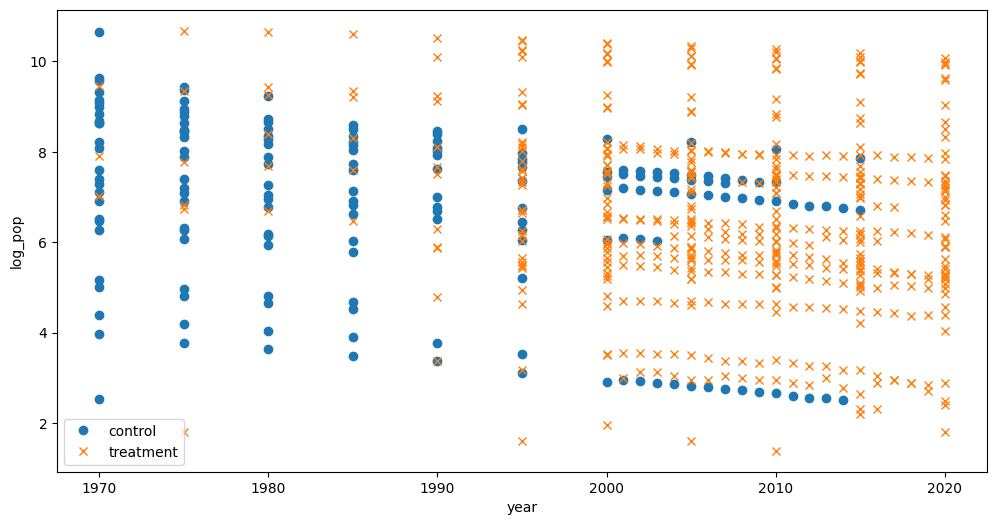

In [179]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(treatment_group['year'], pred_mu, 'o', label='control')
ax.plot(treatment_df['year'], treatment_df['log_pop'], 'x', label='treatment')

plt.xlabel('year')
plt.ylabel('log_pop')
plt.legend()
plt.show()